In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
DATA_DIR  = Path("data")
TRAIN_DIR = DATA_DIR / "RealWaste"

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # ResNet = 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]), # ImageNet mean, std
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [7]:
base_ds = ImageFolder(TRAIN_DIR)
indices = list(range(len(base_ds)))
labels  = [label for _, label in base_ds.samples]

# Train - Test: 0.8 - 0.2
train_val_idx, test_idx, train_val_labels, test_labels = train_test_split(
    indices, labels,
    train_size=0.8,
    stratify=labels,
    random_state=42
)

# Train - Val: 0.8 - 0.2
train_idx, val_idx, _, _ = train_test_split(
    train_val_idx, train_val_labels,
    test_size=0.20,
    stratify=train_val_labels,
    random_state=42
)

len(train_idx),  len(val_idx), len(test_idx)

(3040, 761, 951)

In [8]:
train_ds = Subset(ImageFolder(TRAIN_DIR, transform=train_transforms), train_idx)
val_ds   = Subset(ImageFolder(TRAIN_DIR, transform=val_transforms), val_idx)
test_ds  = Subset(ImageFolder(TRAIN_DIR, transform=val_transforms), test_idx)

train_loader = DataLoader(train_ds,  batch_size=64, shuffle=True,  num_workers=12)
val_loader   = DataLoader(val_ds,    batch_size=64, shuffle=False, num_workers=12)
test_loader  = DataLoader(test_ds,   batch_size=64, shuffle=False, num_workers=12)

len(train_ds), len(val_ds), len(test_ds)

(3040, 761, 951)

In [13]:
resnet_model.fc.in_features

512

In [15]:
resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # Use pre-trained model

in_features = resnet_model.fc.in_features
num_classes = 9

resnet_model.fc = nn.Sequential(
    nn.Dropout(p=0.5), # Dropout before last nn layer, prevent overfitting
    nn.Linear(in_features, num_classes) 
)
model = resnet_model.to(device)

cross_entropy_loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

scheduler = OneCycleLR( # 
    optimizer,
    max_lr=1e-3,
    final_div_factor=1e4,
    
    steps_per_epoch=len(train_loader),
    epochs=20,  
)


In [16]:
history = {
    "train_acc":[], 
    "train_loss":[], 
    "val_acc":[], 
    "val_loss":[]
}

num_epochs   = 20


for epoch in range(1, num_epochs+1):
    
    model.train()
    
    running_loss, all_preds, all_labels = 0.0, [], []
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # forward
        outputs = model(imgs)

        # compute loss
        loss = cross_entropy_loss(outputs, labels)
        
        # back propagation
        loss.backward() 
        
        optimizer.step() # update weights
        scheduler.step() # update learning rate
        
        running_loss += loss.item() * imgs.size(0)
        
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    train_loss = running_loss / len(train_loader.dataset)
    train_acc  = accuracy_score(all_labels, all_preds)

    
    # validation
    
    model.eval()
    
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            # forward
            outputs = model(imgs)

            # computer loss
            loss = cross_entropy_loss(outputs, labels)

            
            running_loss += loss.item() * imgs.size(0)
            
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    val_loss = running_loss / len(val_loader.dataset)
    val_acc  = accuracy_score(all_labels, all_preds)
    
    print(f"Epoch {epoch}: Train Loss {train_loss:.3f}, Accuracy {train_acc:.3f} | Val Loss {val_loss:.3f}, Accuracy {val_acc:.3f}")

    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)




Epoch 1: Train Loss 2.484, Accuracy 0.124 | Val Loss 2.103, Accuracy 0.223
Epoch 2: Train Loss 2.056, Accuracy 0.257 | Val Loss 1.603, Accuracy 0.464
Epoch 3: Train Loss 1.586, Accuracy 0.436 | Val Loss 1.162, Accuracy 0.637
Epoch 4: Train Loss 1.235, Accuracy 0.576 | Val Loss 0.898, Accuracy 0.733
Epoch 5: Train Loss 1.009, Accuracy 0.661 | Val Loss 0.755, Accuracy 0.770
Epoch 6: Train Loss 0.883, Accuracy 0.695 | Val Loss 0.667, Accuracy 0.778
Epoch 7: Train Loss 0.813, Accuracy 0.710 | Val Loss 0.605, Accuracy 0.799
Epoch 8: Train Loss 0.715, Accuracy 0.749 | Val Loss 0.549, Accuracy 0.812
Epoch 9: Train Loss 0.664, Accuracy 0.772 | Val Loss 0.514, Accuracy 0.815
Epoch 10: Train Loss 0.613, Accuracy 0.787 | Val Loss 0.484, Accuracy 0.832
Epoch 11: Train Loss 0.552, Accuracy 0.810 | Val Loss 0.473, Accuracy 0.840
Epoch 12: Train Loss 0.530, Accuracy 0.815 | Val Loss 0.440, Accuracy 0.850
Epoch 13: Train Loss 0.508, Accuracy 0.826 | Val Loss 0.428, Accuracy 0.852
Epoch 14: Train Loss 

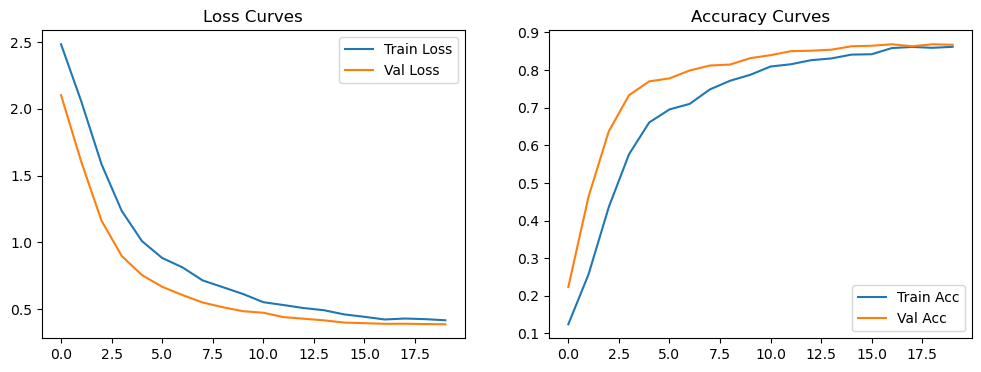

In [18]:
# Loss and accuracy curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.legend(); plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.legend(); plt.title("Accuracy Curves")
plt.show()


In [19]:
# Test accuracy and evaluation report
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        test_preds.extend(outputs.argmax(1).cpu().numpy())
        test_labels.extend(labels.numpy())

print("Test Accuracy:", accuracy_score(test_labels, test_preds))
print(classification_report(test_labels, test_preds, target_names=base_ds.classes))
#print("Confusion Matrix:\n", confusion_matrix(test_labels, test_preds))

Test Accuracy: 0.8569926393270242
                     precision    recall  f1-score   support

          Cardboard       0.86      0.87      0.86        92
      Food Organics       0.91      0.95      0.93        82
              Glass       0.88      0.85      0.86        84
              Metal       0.84      0.88      0.86       158
Miscellaneous Trash       0.78      0.63      0.69        99
              Paper       0.86      0.89      0.88       100
            Plastic       0.82      0.85      0.84       185
      Textile Trash       0.84      0.83      0.83        64
         Vegetation       0.98      0.98      0.98        87

           accuracy                           0.86       951
          macro avg       0.86      0.86      0.86       951
       weighted avg       0.86      0.86      0.86       951



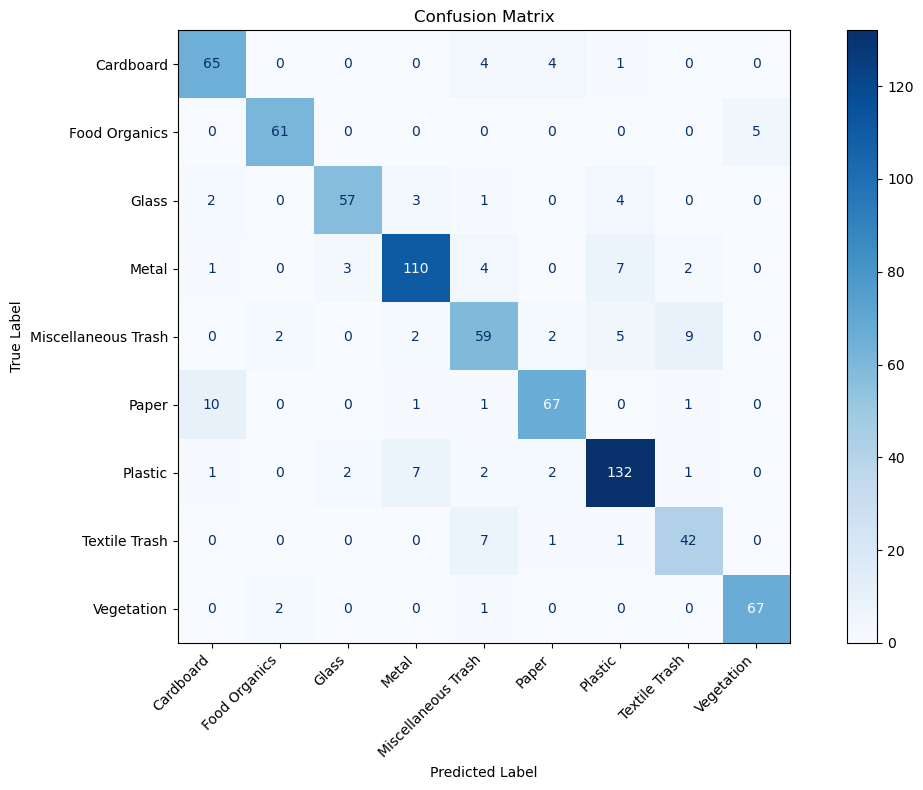

In [30]:
# confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=base_ds.classes)
disp.plot(ax=ax, cmap=plt.cm.Blues)

ax.set_xticklabels(base_ds.classes, rotation=45, ha="right")
ax.set_ylabel("True Label")
ax.set_xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

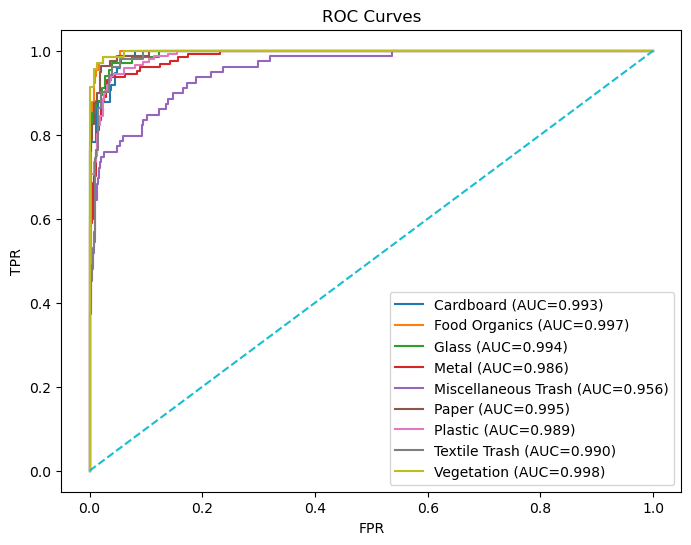

In [34]:
# ROC curves
probs, true = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outs = model(imgs)
        probs.append(torch.softmax(outs, dim=1).cpu().numpy())
        true.append(labels.numpy())

probs = np.vstack(probs)
true  = np.hstack(true)



y_label = label_binarize(true, classes=list(range(len(base_ds.classes))))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(base_ds.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], probs[:,i])
    roc_auc[i]        = auc(fpr[i], tpr[i])


plt.figure(figsize=(8,6))

for i, label in enumerate(base_ds.classes):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC={roc_auc[i]:.3f})")

plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curves") 
plt.legend()
_ = plt.show()
